# Trabajo Final de Grado
## Detección, Reconocimineto y Seguimiento de Rostros Aplicando Redes Neuronales Convolucionales

### Autor: Alejandro Bautista Gómez
### Tutor: Ruben Martín Clemente

In [1]:
# Trabajo Final de Grado de Alejandro Bautista Gómez

"""
En esta celda utilizamos los comandos para montar nuestro entorno de trabajo en 
Google Drive, así como instalar los siguientes módulos
#
#  face_recognition: la red neuronal con la que detectamos y realizamos 
operaciones con caras
#
"""
from google.colab import drive
drive.mount('/content/drive')
%cd drive/'My Drive'/Programa
!pip install -q face_recognition


"""
En esta celda importaremos algunos de los módulos que se emplearán en este 
trabajo

Nota: Timing es un wrapper, una función decoradora que nos permitirá calcular 
los tiempos de ejecución de los distintos procesos
"""

import numpy as np
import sys
import face_recognition #Librería de reconocimiento facial
import os #Librería para interactuar con el entorno
import cv2 #Librería de visión artificial
from sklearn.neural_network import MLPClassifier #Clasificador MLP
from sklearn.neighbors import KNeighborsClassifier #Clasificador KNN
from sklearn.ensemble import RandomForestClassifier #Clasificador RF
from sklearn.svm import SVC #Clasificador SVM
from sklearn.externals import joblib #Para guardar/cargar clases en archivos
import pandas as pd

from functools import wraps
from time import time, sleep
from typing import List
import dlib

def timing(f):
    @wraps(f)
    def wrapper(*args, **kwargs):
        start = time()
        result = f(*args, **kwargs)
        end = time()
        print('Function: {}. Elapsed time: {}'.format(f, end-start))
        return result

    return wrapper

face_recognition.face_encodings = timing(face_recognition.face_encodings)
face_recognition.face_locations = timing(face_recognition.face_locations)


dlib.DLIB_USE_CUDA #Devuelve True en caso de que se estén utilizando GPU

Mounted at /content/drive
/content/drive/My Drive/Programa
     |████████████████████████████████| 100.2MB 41kB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


True

In [2]:
"""
En esta celda se definen:

  load_dir: función que carga la ruta del directorio donde se almacenan los datos de entrenamiento
  
  load_data: función que carga los datos de entrenamiento

  get_data: función que llama a load_data. Si no existen ficheros .pkl ejecuta load_data, si existen, introducir True o False para indicar si se desea entrenar de nuevo la red

  La ruta será /My Drive/programa/Personas 
  En ella estarán los directorios con nombre e imagenes de la persona que se quiera identificar en formato .jpg o .png.
  Se recomienda un mínimo de [30] imagenes de la persona que se quiera identificar para entrenar al clasificador.
"""

@timing
def load_dir(directorio, encodings_final, index, tags):
    path= './Personas/' + directorio +'/'
    #Lista con los nombres de las imágenes de la carpeta de la persona
    file_list = os.listdir(path)
    for imagen in file_list:
        #Forma la ruta de la imagen
        complete_path= path + imagen
        #Carga la imagen y extrae su codificación (encodings)
        imagen = face_recognition.load_image_file(complete_path)
        encodings = face_recognition.face_encodings(imagen)
        #Si se ha obtenido, se añade a la lista final de encodings y de etiquetas
        if encodings:
            encodings_final.append(encodings[0])
            tags.append(index)


def load_data():
    #Por defecto, se tomará la carpeta Source
    dirs=os.listdir(path='./Personas')
    
    #Inicializando parámetros
    encodings_final=[]
    tags=[]
    known_names=[]
    n_samples = 0

    print("Analizando directorios:")
    for (directorio,index) in zip(dirs, range(len(dirs))):
        #Muestra el directorio analizado
        load_dir(directorio, encodings_final, index, tags)
        print(str(index+1) + ') ' + directorio + ' - ' + str(len(tags) - n_samples))
        #Suponiendo que hay al menos un rostro correcto en cada directorio
        known_names.append(directorio)
        n_samples = len(tags)

    return encodings_final, known_names, tags


def get_data(select):
  if ((not os.path.exists('Model/Names.pkl')) or (not os.path.exists('Model/Encodings_final.pkl')) or (not os.path.exists('Model/Tags.pkl')) ):
    encodings_final, known_names, tags = load_data()
    joblib.dump(known_names, './Model/Names.pkl')
    joblib.dump(encodings_final, './Model/Encodings_final.pkl')
    joblib.dump(tags, './Model/Tags.pkl')
    if not tags:
      raise "No images found! Need some images to train a classifier"
    else:
      return known_names, encodings_final, tags
  else:
    if (select == True):
      encodings_final, known_names, tags = load_data()
      joblib.dump(known_names, './Model/Names.pkl')
      joblib.dump(encodings_final, './Model/Encodings_final.pkl')
      joblib.dump(tags, './Model/Tags.pkl')
      return known_names, encodings_final, tags
    else:
      known_names = joblib.load('Model/Names.pkl')
      encodings_final = joblib.load('Model/Encodings_final.pkl')
      tags = joblib.load('Model/Tags.pkl')
      return known_names, encodings_final, tags

""""
Extrae caracteristicas en caso de no existir los ficheros: Names.pkl, Encodings_final.pkl o Tags.pkl
True: sobreescribe los archivos actuales y carga los ficheros .pkl en los objetos
False: carga los ficheros .pkl en los objetos
"""
[known_names, encodings_final, tags] = get_data(False)

In [3]:
print(known_names)

['Berto ', 'Ignatius ', 'Ibai', 'Hobi', 'Broncano', 'Glover', 'Buenafuente', 'Queque', "Lupita Nyong'o", 'Mari Kondo']


In [4]:
"""
Función de entrenamiento de modelo Multi Layer Perceptron
"""
@timing
def train_mlp(encodings_final, tags):
    #Si se han obtenido algunas etiquetas (y por tanto encodings)
    #Crea y entrena el clasificador
    clf = MLPClassifier(max_iter=1000, activation= 'tanh', hidden_layer_sizes = (200,100,50))
    model = clf.fit(encodings_final, tags)
    #Guarda el modelo de MLP entrenado y la lista de nombres
    joblib.dump(model, './Model/MLPClassifier.pkl')
    print("Clasificador MLP creado.")

"""
Función de entrenamiento de modelo con K-Nearest Neighbours
"""
@timing
def train_knn(encodings_final, tags):
    #Si se han obtenido algunas etiquetas (y por tanto encodings)
    #Crea y entrena el clasificador
    clf = KNeighborsClassifier(n_neighbors=13, weights='uniform')
    model = clf.fit(encodings_final, tags)
    #Guarda el modelo de KNN entrenado y la lista de nombres
    joblib.dump(model, './Model/KNNClassifier.pkl')
    print("Clasificador KNN creado.")
"""
Función de entrenamiento
"""
@timing
def train_rf(encodings_final, tags):
    #Si se han obtenido algunas etiquetas (y por tanto encodings)
    #Crea y entrena el clasificador
    clf = RandomForestClassifier(n_estimators=25)
    model = clf.fit(encodings_final, tags)
    #Guarda el modelo de RF entrenado y la lista de nombres
    joblib.dump(model, './Model/RFClassifier.pkl')
    print("Clasificador RF creado.")

"""
Función de entrenamiento SVM
"""
@timing
def train_svm(encodings_final, tags):
    #Si se han obtenido algunas etiquetas (y por tanto encodings)
    #Crea y entrena el clasificador
    clf = SVC(probability=True, kernel='rbf')
    model = clf.fit(encodings_final, tags)
    #Guarda el modelo de SVM entrenado y la lista de nombres
    joblib.dump(model, './Model/SVMClassifier.pkl')
    print("Clasificador SVM creado.")

#encodings_final, known_names, tags = load_data()

#if (encodings_final == 'None'):
#  encodings_final, known_names, tags = load_data()


train_mlp(encodings_final, tags)
train_knn(encodings_final, tags)
train_rf(encodings_final, tags)
train_svm(encodings_final, tags)

Clasificador MLP creado.
Function: <function train_mlp at 0x7f3a644b77b8>. Elapsed time: 1.8928563594818115
Clasificador KNN creado.
Function: <function train_knn at 0x7f3a644b7ae8>. Elapsed time: 0.49665164947509766
Clasificador RF creado.
Function: <function train_rf at 0x7f3a644b7b70>. Elapsed time: 0.3896524906158447
Clasificador SVM creado.
Function: <function train_svm at 0x7f3a644b7d08>. Elapsed time: 0.6259396076202393


In [5]:
from google.colab.patches import cv2_imshow
class SkleanClassifier():

  def __init__(self, model_path, names_path):
    self.model = joblib.load(model_path)
    self.names = joblib.load(names_path)

  @timing
  def __call__(self, face_encodings, conf_thr=0.7):
    if len(face_encodings) == 0:
      return []

    preds = self.model.predict_proba(face_encodings)  # get the predictions

    predictions = []
    for pred in preds:  # map predictions to names and confidence
      conf = max(pred)
      if conf < conf_thr:
        name = "Unknown"
      else:
        tag = np.argmax(pred)
        name = self.names[tag]
      predictions.append((name, conf))

    return predictions


class Face():
    def __init__(self, face_location, face_encoding, name, conf, frame_idx=None):
        self.frame_idx = frame_idx
        self.location = face_location
        self.y1, self.x2, self.y2, self.x1 = self.location
        self.encoding = face_encoding
        self.name = name
        self.conf = conf
        self.label = name + f" {self.conf:.2f}"
        self.color = (255, 0, 0)  # blue by default

    def draw_on_img(self, img):
        c1, c2 = (self.x1, self.y1), (self.x2, self.y2)
        cv2.rectangle(img, c1, c2, (255, 0, 0), 2)
        tf = 1  # font thickness
        tl = 0.5
        t_size = cv2.getTextSize(self.label, 0, fontScale=tl, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, self.color, -1)  # filled
        cv2.putText(
            img,
            self.label,
            (c1[0], c1[1] - 2),
            0,
            tl,
            [225, 255, 255],
            thickness=tf,
            lineType=cv2.LINE_AA,
        )

    def todict(self):
        return {
            "x1": self.x1,
            "y1": self.y1,
            "x2": self.x2,
            "y2": self.y2,
            "name": self.name,
            "conf": self.conf,
            "frame_idx": self.frame_idx,
        }


class ProcessingPipeline():

    def __init__(self, classifier):
        self.classifier = classifier

    @timing
    def __call__(self, img, frame_idx=None) -> List[Face]:
        rgb_frame = img[:, :, ::-1]  # BGR to RGB
        face_locations = face_recognition.face_locations(rgb_frame, model="cnn")
        face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)
        predictions = self.classifier(face_encodings)

        faces = []
        for fl, fe, (name, conf) in zip(face_locations, face_encodings, predictions):
          faces.append(Face(fl, fe, name, conf, frame_idx))
        return faces


names_path = './Model/Names.pkl'
# Test MLP
model_path = './Model/MLPClassifier.pkl'
mlp_classifier = SkleanClassifier(model_path, names_path)

# Test KNN
model_path = './Model/KNNClassifier.pkl'
knn_classifier = SkleanClassifier(model_path, names_path)

# Test RF
model_path = './Model/RFClassifier.pkl'
rf_classifier = SkleanClassifier(model_path, names_path)


# Test SVM
model_path = './Model/SVMClassifier.pkl'
svm_classifier = SkleanClassifier(model_path, names_path)

""" IMPORTANTE:
    En la siguiente linea hay que introducir uno de los 3 clasificadores entrenados para ProccesingPipeline:
    mlp_classifier: clasificador Multi Layer Perceptron 
    knn_classifier: clasificador K-Nearest Neighbours
    rf_classifier : clasificador Random Forest
    svm_classifier : clasificador State Vector Machine
"""
processing_pipe = ProcessingPipeline(svm_classifier)

## Entrenamiento - Clasificación

In [6]:
"""
Banco de pruebas 1:  Valided de clasificador. El objetivo de este banco de pruebas es el de validar a los modelos de clasificación entrenados. Para ello, 
utilizamos dichos modelos comparados con vectores aleatorios de 128 dimensiones. La forma de comparar qun modelo es más eficiente será comparando el número de falsos positivos detectados por
el sistema en forma de "personas identificadas" y el valor medio de confianza otorgado por este
"""
@timing
def false_positves_on_classifier(predictions):
  false_positives=0
  avg_conf = 0
  for i in predictions:
   if (i[1] >=0.8):
      false_positives = false_positives + 1
   avg_conf = avg_conf + i[1]
  avg_conf = avg_conf/len(predictions)
  print("Número de predicciones erroneas",false_positives,"\n"+"Confianza media", avg_conf)

random_vectors = np.random.rand(1000, 128)
print('Clasificador MLP')
false_positves_on_classifier(mlp_classifier(random_vectors))
print('Clasificador KNN')
false_positves_on_classifier(knn_classifier(random_vectors))
print('Clasificador RF')
false_positves_on_classifier(rf_classifier(random_vectors))
print('Clasificador SVM')
false_positves_on_classifier(svm_classifier(random_vectors))

Clasificador MLP
Function: <function SkleanClassifier.__call__ at 0x7f3a6451c6a8>. Elapsed time: 0.029368162155151367
Número de predicciones erroneas 503 
Confianza media 0.7665385031427372
Function: <function false_positves_on_classifier at 0x7f3a644ce2f0>. Elapsed time: 0.0005750656127929688
Clasificador KNN
Function: <function SkleanClassifier.__call__ at 0x7f3a6451c6a8>. Elapsed time: 0.10585260391235352
Número de predicciones erroneas 58 
Confianza media 0.5376923076923074
Function: <function false_positves_on_classifier at 0x7f3a644ce2f0>. Elapsed time: 0.0005600452423095703
Clasificador RF
Function: <function SkleanClassifier.__call__ at 0x7f3a6451c6a8>. Elapsed time: 0.009735107421875
Número de predicciones erroneas 0 
Confianza media 0.23636000000000018
Function: <function false_positves_on_classifier at 0x7f3a644ce2f0>. Elapsed time: 0.0007355213165283203
Clasificador SVM
Function: <function SkleanClassifier.__call__ at 0x7f3a6451c6a8>. Elapsed time: 0.05001688003540039
Númer

Function: <function face_locations at 0x7f3aac184378>. Elapsed time: 5.0165770053863525
Function: <function face_encodings at 0x7f3aac184620>. Elapsed time: 1.4868123531341553
Function: <function SkleanClassifier.__call__ at 0x7f3a6451c6a8>. Elapsed time: 0.0006549358367919922
Function: <function ProcessingPipeline.__call__ at 0x7f3a6451c9d8>. Elapsed time: 6.504432678222656
{'x1': 441, 'y1': 70, 'x2': 559, 'y2': 188, 'name': 'Ignatius ', 'conf': 0.7361376229116975, 'frame_idx': None}


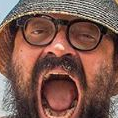

{'x1': 681, 'y1': 67, 'x2': 779, 'y2': 165, 'name': 'Unknown', 'conf': 0.37574392937474516, 'frame_idx': None}


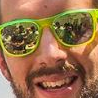

{'x1': 213, 'y1': 117, 'x2': 312, 'y2': 215, 'name': 'Unknown', 'conf': 0.6225376502111117, 'frame_idx': None}


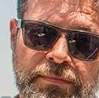

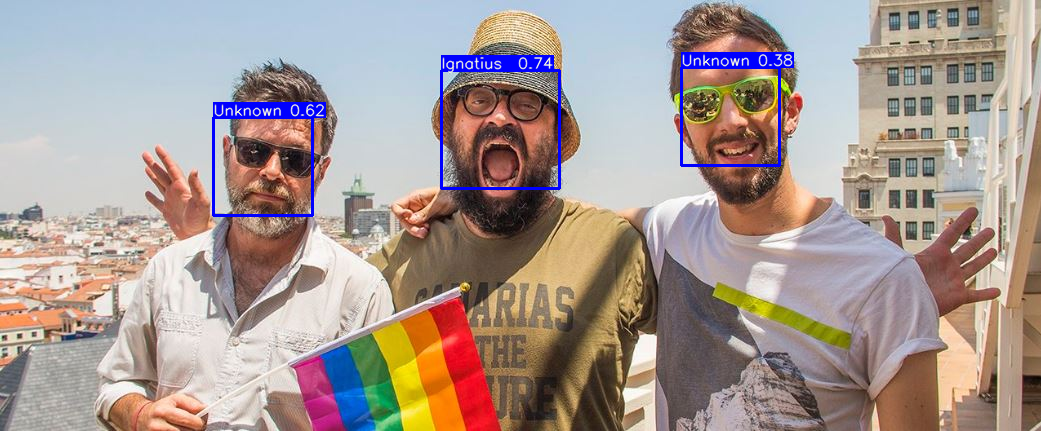

In [7]:
"""
Banco de pruebas 2: Valided de clasificador. El objetivo de este banco de pruebas es el de validar a los modelos de clasificación entrenados. Para ello, utilizamos los modelos ya entrenados
con imágenes de personas alojadas en el directorio raiz y comprobamos si dichas personas son clasificadas de manera correcta. 
"""
input_img = 'Imagenes/10.jpeg'
img = cv2.imread(input_img) #Esta linea indica el nombre del archivo y el formato
faces = processing_pipe(img)
for face in faces:
  print(face.todict())
  crop_img = img[face.y1:face.y2, face.x1:face.x2]
  cv2_imshow(crop_img)
  face.draw_on_img(img)
cv2_imshow(img)

In [8]:
class VideoLoader():
    """
    This class controls how frames are taken from the camera
    """

    def __init__(self, video_path, downsampling_factor=1):
        self.downsampling_factor = downsampling_factor
        self.source = video_path
        self.cap = cv2.VideoCapture(self.source)
        self.shape = self.cap.read()[1].shape
        self.cap = cv2.VideoCapture(self.source)
        self.total_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
        self.latency = 1.0 / self.fps
        self.taken_fps = self.fps / self.downsampling_factor
        self.frame_counter = 0

    def read(self):
        """
        Read one Frame from video. Return None if none left.
        """
        while self.frame_counter % self.downsampling_factor:  # Throw away
            _, img = self.cap.read()
            self.frame_counter += 1
        # read frame from video
        _, img = self.cap.read()

        # condition to finish iterating
        if img is None:
            print("[VideoLoader]: Reached end of video")
            return None

        return img

    def release(self):
        self.cap.release()

    def __iter__(self):
        return self

    def __next__(self):
        frame = self.read()
        if frame is None:
            raise StopIteration()
        else:
            return frame


class VideoWriter():
    """
    This class, active in debug mode, offers an simple interface to writting
    visualizations over input frames.
    """

    def __init__(self, save_path, shape, fps):
        self.fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        self.fps = fps
        self.shape = shape

        self.writer = cv2.VideoWriter(
            save_path,
            self.fourcc,
            self.fps,
            self.shape[:2][::-1],
        )

    def release(self):
        self.writer.release()

    def write(self, img):
        self.writer.write(img)

In [9]:
from itertools import cycle

class IDGenerator():
    def __init__(self, max_id=10e9):
        max_id = int(max_id)
        self.iterator = cycle(range(max_id))

    def __next__(self):
        return next(self.iterator)


color_dict = {
    "purple": (255, 0, 255),
    "blue": (255, 0, 0),
    #"yellow": (0, 255, 255),
    "red": (0, 0, 255),
    "green": (0, 255, 0),  # reserved for the detector
    "skyblue": (235, 206, 135),
    "navyblue": (128, 0, 0),
    "azure": (255, 255, 240),
    "slate": (255, 0, 127),
    "choco": (30, 105, 210),
    "olive": (112, 255, 202),
    "orange": (0, 140, 255),
    "orchid": (255, 102, 224),
}
colors = list(color_dict.values())


class Object():
    '''
    Tracked Object.
    '''

    def __init__(self, face, given_id, fps):
        self.id = given_id
        self.fps = int(fps)
        self.n_observations = 1
        self.unseen_ticks = 0
        self.unseen_secs = 0
        self.location = face.location
        self.encoding = face.encoding
        self.y1, self.x2, self.y2, self.x1 = self.location
        self.color = colors[given_id % len(color_dict)]
        self.name = face.name
        self.conf = face.conf
        self.lock_name = False
        if (self.name != 'Unknown'):
          self.label = self.name
          self.lock_name = True
        else:
          self.label = self.get_label()


    def unseen(self):
        self.unseen_ticks += 1
        self.unseen_secs = self.unseen_ticks / self.fps

    def update(self, face):
        self.unseen_ticks = 0
        self.n_observations += 1
        self.location = face.location
        # Optionally you could do spatial smoothing
        # self.location = np.mean(np.array([self.location, face.location]), axis=0).astype(np.int32).tolist()
        # Averaging the encodings with past ones makes it closer to the centroid of the class
        self.encoding = np.mean(np.array([self.encoding, face.encoding]), axis=0).tolist()
        self.y1, self.x2, self.y2, self.x1 = self.location 
        self.conf = face.conf
        if (self.lock_name == False):
          self.name = face.name
          self.label = self.get_label()
          
          if (self.name != 'Unknown'):
            self.lock_name = True
        
        else:
          self.label = self.name
                      
          

    def get_label(self):
        return "ID: " + str(self.id)

    def draw_on_img(self, img):  
        c1, c2 = (self.x1, self.y1), (self.x2, self.y2)
        cv2.rectangle(img, c1, c2, self.color, 2)
        tf = 1  # font thickness
        tl = 0.5
        t_size = cv2.getTextSize(self.label, 0, fontScale=tl, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, self.color, -1)  # filled
        cv2.putText(
            img,
            self.label,
            (c1[0], c1[1] - 2),
            0,
            tl,
            [225, 255, 255],
            thickness=tf,
            lineType=cv2.LINE_AA,
        )


class FaceTracker():
    def __init__(self, fps, max_unseen_secs=5, dist_thr=0.7):
        self.fps = fps
        self.max_unseen_secs = max_unseen_secs  # Seconds until track is lost
        self.dist_thr = dist_thr

        self.id_generator = IDGenerator()
        self.active_objects = []

    def pair_faces_to_objects(self, faces: List[Face], objects: List[Object]):
        all_pairs = []
        for i, face in enumerate(faces):
            for ii, obj in enumerate(objects):
                # using only encoding info. TODO: add location to help assignation
                dist = np.linalg.norm(face.encoding - obj.encoding)  # see: https://face-recognition.readthedocs.io/en/latest/_modules/face_recognition/api.html#face_distance
                if dist < self.dist_thr:  # We want pairs that are close
                    all_pairs.append([dist, i, ii])
        
        # Greedy assignation
        all_pairs = sorted(all_pairs)  # sorts by distance
        f_idx_list, o_idx_list = [], []
        for pair in all_pairs:
            f_idx, o_idx = pair[1], pair[2]
            if (f_idx in f_idx_list) or (o_idx in o_idx_list):
                pass  # if they are already assigned, pass
            else:
                f_idx_list.append(f_idx)
                o_idx_list.append(o_idx)

        return list(zip(f_idx_list, o_idx_list))

    @timing        
    def update(self, faces: List[Face]):
        # Init in first iteration
        if not self.active_objects:
            self.active_objects = [Object(face, next(self.id_generator), self.fps) for face in faces]
            return

        # 1. Pair new faces to objects
        pairs = self.pair_faces_to_objects(faces, self.active_objects)
        for (f_idx, o_idx) in pairs:
            face = faces[f_idx]
            obj = self.active_objects[o_idx]
            obj.update(face)  # Propagate ID

        # 2. Push unseen counter of not paired objects
        assigned_obj_idxs = [pair[1] for pair in pairs]
        unassigned_objs = [
            obj
            for i, obj in enumerate(self.active_objects)
            if i not in assigned_obj_idxs
        ]
        [obj.unseen() for obj in unassigned_objs]

        # 3. Delete objects if not seen for a while
        marked_for_del = []
        for i, obj in enumerate(self.active_objects):
            if obj.unseen_secs > self.max_unseen_secs:
                marked_for_del.append(i)

        self.active_objects = [
            obj for i, obj in enumerate(self.active_objects) if i not in marked_for_del
        ]

        # 4. Create new active_objects from unassigned detections
        assigned_face_idxs = [pair[0] for pair in pairs]
        unassigned_faces = [
            face
            for i, face in enumerate(faces)
            if i not in assigned_face_idxs
        ]
        for face in unassigned_faces:
            self.active_objects.append(Object(face, next(self.id_generator), self.fps))

In [ ]:
input_video = 'Videos/prueba_track.mp4'
save_path = 'Videos/prueba_track_output.mp4'

@timing
def process_video_tracking(input_video, save_path):
    video_loader = VideoLoader(input_video, downsampling_factor=1)
    video_writer = VideoWriter(save_path, video_loader.shape, video_loader.taken_fps)
    face_tracker = FaceTracker(video_loader.taken_fps, max_unseen_secs=10, dist_thr=0.6)   

    for img in video_loader:
        faces = processing_pipe(img)
        print(faces)
        face_tracker.update(faces)
        [obj.draw_on_img(img) for obj in face_tracker.active_objects if obj.unseen_ticks == 0]  # Draw debugging
        video_writer.write(img)

    video_loader.release()
    video_writer.release()

process_video_tracking(input_video, save_path)

Clasificador SVM creado.
Function: <function train_svm at 0x7f1f0eb96158>. Elapsed time: 0.21465635299682617


In [ ]:
"""
Esta celda 
En esta linea introducimos el nombre de la ruta del archivo que vamos a analizar
La ruta siempre es "Videos/..."
"""

input_video = 'Videos/Test.mp4'
save_path = 'Videos/Test_out.mp4'

@timing
def process_video(input_video, save_path):
    video_loader = VideoLoader(input_video, downsampling_factor=1)
    video_writer = VideoWriter(save_path, video_loader.shape, video_loader.taken_fps)

    for img in video_loader:
        faces = processing_pipe(img)
        [face.draw_on_img(img) for face in faces]  # Draw debugging
        video_writer.write(img)

    video_loader.release()
    video_writer.release()

process_video(input_video, save_path)

Function: <function face_locations at 0x7f3c7fdb80d0>. Elapsed time: 0.3824596405029297
Function: <function face_locations at 0x7f3c4ac78ae8>. Elapsed time: 0.38264942169189453
Function: <function face_encodings at 0x7f3c7fdb8378>. Elapsed time: 0.024165630340576172
Function: <function face_encodings at 0x7f3c4ac78a60>. Elapsed time: 0.02426004409790039
Function: <function SkleanClassifier.__call__ at 0x7f3c4abd00d0>. Elapsed time: 0.00519251823425293
Function: <function ProcessingPipeline.__call__ at 0x7f3c4abd01e0>. Elapsed time: 0.4123356342315674
Function: <function face_locations at 0x7f3c7fdb80d0>. Elapsed time: 0.3623955249786377
Function: <function face_locations at 0x7f3c4ac78ae8>. Elapsed time: 0.36251354217529297
Function: <function face_encodings at 0x7f3c7fdb8378>. Elapsed time: 0.026513099670410156
Function: <function face_encodings at 0x7f3c4ac78a60>. Elapsed time: 0.026605606079101562
Function: <function SkleanClassifier.__call__ at 0x7f3c4abd00d0>. Elapsed time: 0.0048

KeyboardInterrupt: ignored